# Project: Finding Lane Lines on the Road

***
This project is to identify lane lines on the road, the images and videos used here are just copied from Udacity repository. 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


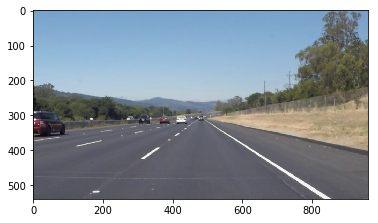

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  

## Helper Functions

Below are some helper functions to help get started. 

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    l_slope_sum = 0
    r_slope_sum = 0
    l_num = 0
    r_num = 0
    l_x_sum = 0
    l_y_sum = 0    
    r_x_sum = 0
    r_y_sum = 0    
  
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=((y1-y2)/(x1-x2))
            if (slope < -0.6 and slope > -0.9):
                l_slope_sum += slope
                l_num = l_num + 1
                l_x_sum = l_x_sum + x1 + x2
                l_y_sum = l_y_sum + y1 + y2
            elif (slope > 0.45 and slope < 0.75):
                r_slope_sum += slope
                r_num = r_num + 1
                r_x_sum = r_x_sum + x1 + x2
                r_y_sum = r_y_sum + y1 + y2

    if l_num != 0 :
        l_slope = l_slope_sum / l_num
        l_x_avg = int(l_x_sum / (2*l_num) )
        l_y_avg = int(l_y_sum / (2*l_num) )  
        l_y1 = 310
        l_x1 = int( (l_y1 - l_y_avg)/l_slope + l_x_avg )
        l_y2 = int(imshape[0])
        l_x2 = int( (l_y2 - l_y_avg)/l_slope + l_x_avg )
        cv2.line(img, (l_x1, l_y1), (l_x2, l_y2), color=(255,0,0), thickness=3)
        
    if r_num != 0 :
        r_slope = r_slope_sum / r_num
        r_x_avg = int(r_x_sum / (2*r_num) )
        r_y_avg = int(r_y_sum / (2*r_num) ) 
        r_y1 = 310
        r_x1 = int( (r_y1 - r_y_avg)/r_slope + r_x_avg )
        r_y2 = int(imshape[0])
        r_x2 = int( (r_y2 - r_y_avg)/r_slope + r_x_avg )
        cv2.line(img, (r_x1, r_y1), (r_x2, r_y2), color=(0,255,0), thickness=3)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Lane Finding Pipeline



### Convert to gray image

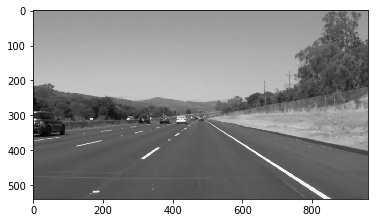

In [4]:
gray = grayscale(image)
plt.imshow(gray, cmap='gray')

### Apply Gaussian Blur

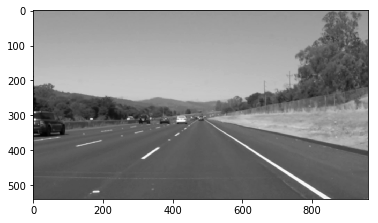

In [5]:
kernel_size = 5 
blur_gray = gaussian_blur(gray,kernel_size) 
plt.imshow(blur_gray, cmap='gray')

### Canny Edge Detection

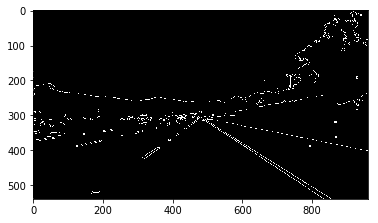

In [6]:
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

### Region of Interest

imshape is: (540, 960)


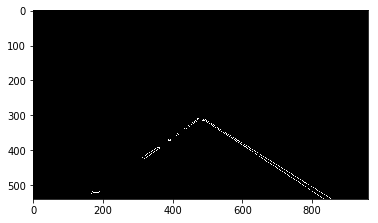

In [7]:
imshape = edges.shape
print('imshape is:', imshape)

vertices = np.array([[(0,imshape[0]),(450, 310), (490, 310), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges, cmap='gray')

### Hough transform 

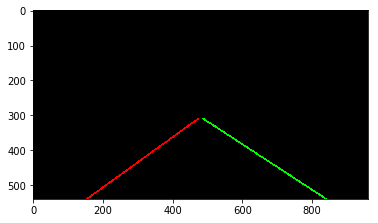

In [8]:
"""Define the Hough transform parameters
Increasing the value threshold increases the minimum number of intersection required to detect a line and thus is 
able to differentiate between the left and right lanes better
min_line_len as the name suggests will help you make sure that the line segments are drawn on the actual lines and 
thus help eliminate some of the lines.
Increasing your value of max_line_gap will help you get more connected annotated lines when there are broken lanes 
as it allow points that are farther away from each other to be connected with a single line.
"""
rho = 2            # distance resolution in pixels of the Hough grid
theta = np.pi/180  # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 100 # minimum number of pixels making up a line
max_line_gap = 160 # maximum gap in pixels between connectable line segments

lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(lines, cmap='gray')

### Overlay images and save

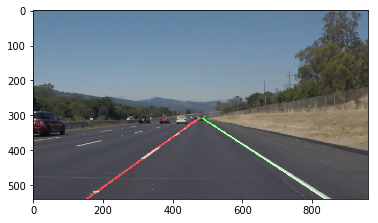

In [9]:
target = weighted_img(lines, image)
plt.imshow(target)
plt.imsave('test_images_output/solidWhiteRightWithLines.jpg', target)

## Test on Videos

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(image):
    gray = grayscale(image)

    kernel_size = 5 
    blur_gray = gaussian_blur(gray,kernel_size) 

    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    imshape = edges.shape
    vertices = np.array([[(0,imshape[0]),(450, 310), (490, 310), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    rho = 2            # distance resolution in pixels of the Hough grid
    theta = np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 100 # minimum number of pixels making up a line
    max_line_gap = 160 # maximum gap in pixels between connectable line segments

    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    result = weighted_img(lines, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,10)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 250/251 [00:07<00:00, 32.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 8.16 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,10)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▊| 250/251 [00:07<00:00, 33.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 9.28 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))